In [3]:
import os
os.chdir(r'/content/drive/MyDrive/Work/PI_deepOnet_General/Anti_derivative')
# os.chdir(r'C:\Users\Feliz\Desktop\jupyter\DeepOnet_General\Antid')
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.io
import math
import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
import os
import csv
#from models import Green_transformer

class SimpleCSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath

        # If the file doesn't exist, create one with headers.
        if not os.path.exists(filepath):
            with open(filepath, 'w', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['epoch', 'metric', 'value'])

    def log(self, epoch, metric, value):
        with open(self.filepath, 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow([epoch, metric, value])

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#from utilities3 import *
Data = scipy.io.loadmat('Data.mat')
Fs = torch.tensor(Data['v'], dtype = torch.float32).to(device)
# COOR = torch.tensor(Data['coors'], dtype = torch.float32)
COOR = torch.linspace(0,1,Fs.size(1))[None,:,None].to(device)
coor  = COOR.repeat(1,1,1)
Y = torch.tensor(Data['u'], dtype = torch.float32).to(device)

Length = len(Fs)
Fs = Fs[:,:,None]
Y = Y[:,:,None]

labels = torch.linspace(0,511,64).long()
print(labels)

Fs = Fs[:,labels,:]
Y = Y[:,labels,:]
coor = coor[:,labels,:]

torch.manual_seed(0)
np.random.seed(0)

print(coor.size())

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

tensor([  0,   8,  16,  24,  32,  40,  48,  56,  64,  73,  81,  89,  97, 105,
        113, 121, 129, 137, 146, 154, 162, 170, 178, 186, 194, 202, 210, 218,
        227, 235, 243, 251, 259, 267, 275, 283, 292, 300, 308, 316, 324, 332,
        340, 348, 356, 365, 373, 381, 389, 397, 405, 413, 421, 429, 438, 446,
        454, 462, 470, 478, 486, 494, 502, 511])
torch.Size([1, 64, 1])


In [4]:
print(Y.size())
train_size = int(len(Y)*0.8)

Y_train = Y[0:train_size,:,:]
X_train = Fs[0:train_size,:,:]

torch.Size([10000, 64, 1])


In [5]:
class MLP1(nn.Module):
    def __init__(self,width_trunk, width_branch, length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                                           nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                                           nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                                           nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                                           nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class MLP2(nn.Module):
    def __init__(self,width_trunk,width_branch,length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                          nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                          nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                          nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                          nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class trunk(nn.Module):
    def __init__(self, width, length, samples):
        super(trunk, self).__init__()

        self.encoder = nn.Linear(1, width) # input channel is 2: (a(x), x)
        self.w1 = torch.nn.Linear(width, width)
        self.w2 = torch.nn.Linear(width, width)
        self.w3 = torch.nn.Linear(width, width)
        self.w4 = torch.nn.Linear(width, length)

    def forward(self, c):
        c = self.encoder(c)
        c = F.gelu(c)
        c = self.w1(c)
        c = F.gelu(c)
        c = self.w2(c)
        c = F.gelu(c)
        c = self.w3(c)
        c = F.gelu(c)
        c = self.w4(c)
        c = F.gelu(c)
        return c

class branch(nn.Module):
    def __init__(self, width, length):
        super(branch, self).__init__()
        self.branch = MLP2(width_trunk=64,width_branch=64,length=64)

    def forward(self, x):
        x = self.branch(x)
        return x


In [6]:
A = torch.nn.Parameter(torch.rand(train_size,64))
model_trunk = trunk(width=64,length=64,samples=10000).to(device)
print(count_parameters(model_trunk))

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam([
    {'params': model_trunk.parameters()},
    {'params': A}
], lr=1e-4)
num_epochs = 500

batch_size = 20
iter_num = int(train_size/batch_size)

Rec = []

best_loss = np.inf
patience_counter=0
best_weights = None
patience = 300

for ep in range(num_epochs):
    model_trunk.train()
    t1 = default_timer()
    De_mse = 0

    for b in range(iter_num):
        a = A[b*batch_size:(b+1)*batch_size,:].to(device)
        y = Y_train[b*batch_size:(b+1)*batch_size,:,:]

        optimizer.zero_grad()

        tr = model_trunk(coor)

        out = torch.matmul(tr,a.permute(1,0)).permute(2,1,0)

        De = F.mse_loss(out, y)

        mse = De

        mse.backward()
        optimizer.step()

        De_mse += De.item()

    De_mse /= iter_num

    t2 = default_timer()
    print(ep, t2-t1, De_mse)
    recording = [t2-t1, De_mse]
    Rec.append(recording)
#%%

16768
0 2.457371407000039 0.40899433840066196
1 1.3665457570000399 0.40526271030306815
2 1.2295732929999872 0.4020605688914657
3 1.2971553529999937 0.3992013138160109
4 1.2233363770000096 0.39634913723915816
5 1.2105335610000338 0.3931799247860909
6 1.226312188999998 0.3893864670023322
7 1.217489908999994 0.38462810005992654
8 1.2720178339999961 0.37858816180378196
9 1.2839790119999748 0.3712041138112545
10 1.367322876000003 0.36270393528044226
11 1.254535298999997 0.35347137454897165
12 1.1751109950000114 0.3438420038670301
13 1.2001193699999817 0.3340401966869831
14 1.1689111050000065 0.32421923872083425
15 1.2130718750000256 0.3144786911830306
16 1.200663297999995 0.30489036072045567
17 1.2146949899999981 0.295493566095829
18 1.2391647300000272 0.2863051775097847
19 1.3499543650000305 0.2773429274186492
20 1.3757369950000111 0.2685749659314752
21 1.2199564569999666 0.26000518528744576
22 1.190381795999997 0.25154421040788294
23 1.2558112950000009 0.24307201981544493
24 1.24468933899

KeyboardInterrupt: 

In [8]:
tr = model_trunk(coor).squeeze()
tr_Q, tr_R = torch.linalg.qr(tr)
tr_R = tr_R.detach()

model_branch = branch(width=64,length=64).to(device)
optimizer = torch.optim.Adam(model_branch.parameters(), lr=1e-4)

for ep in range(num_epochs):
    model_branch.train()
    t1 = default_timer()
    De_mse = 0

    for b in range(iter_num):
        a = A[b*batch_size:(b+1)*batch_size,:].to(device)
        x = X_train[b*batch_size:(b+1)*batch_size,:,:]

        optimizer.zero_grad()

        br = model_branch(x.squeeze()).permute(1,0)
        RA = torch.matmul(tr_R,a.permute(1,0))

        mse = F.mse_loss(br, RA)

        mse.backward()
        optimizer.step()

        De_mse += mse.item()

    De_mse /= iter_num

    t2 = default_timer()
    print(ep, t2-t1, De_mse)
    recording = [t2-t1, De_mse]
    Rec.append(recording)

0 1.0075808349999988 0.18494991483166814
1 0.9537834589999648 0.015327361971139907
2 0.9433028990000594 0.0065376977290725335
3 0.9358655849999877 0.004486882009368856
4 0.9259196960000509 0.0037446933728642762
5 0.9130064319999747 0.003415612747485284
6 0.9233289049999485 0.003197702446486801
7 0.9308770420000201 0.0030314042340614834
8 0.9584992069999316 0.0028963613748783246
9 0.9446011239999734 0.0027844342967728152
10 1.0090688290000571 0.0026887912425445394
11 1.0250322140000208 0.002599091960291844
12 0.9579938780000248 0.0025194185358122924
13 0.9389986940000199 0.002448840592405759
14 0.9319953880000185 0.0023820194869767874
15 0.9209477470000138 0.0023226880480069667
16 0.9340581459999839 0.0022661018781946042
17 0.921075832999918 0.002217587277700659
18 0.915572060000045 0.002172886225162074
19 0.9497558470000058 0.002134527643065667
20 0.9528091060000179 0.002098480709391879
21 0.9222227860000203 0.002068003829772351
22 0.956792754999924 0.0020368042137124576
23 0.976183104

KeyboardInterrupt: 

In [ ]:
A = torch.nn.Parameter(torch.rand(train_size,64))
model = trunk(width=64,length=64,samples=10000).to(device)

for ep in range(num_epochs):
    model.train()
    t1 = default_timer()
    De_mse = 0

    for b in range(iter_num):
        a = A[b*batch_size:(b+1)*batch_size,:].to(device)
        y = Y_train[b*batch_size:(b+1)*batch_size,:,:]

        optimizer.zero_grad()

        tr = model(coor)

        out = torch.matmul(tr,a.permute(1,0)).permute(2,1,0)

        De = F.mse_loss(out, y)

        mse = De

        mse.backward()
        optimizer.step()

        De_mse += De.item()

    De_mse /= iter_num

    t2 = default_timer()
    print(ep, t2-t1, De_mse)
    recording = [t2-t1, De_mse]
    Rec.append(recording)

In [ ]:
num = 10 #10;20;60
y = Y_train[num,:,:][None,:,:]
print(Y_train.size())

a = A[num,:][None,:].to(device)
tr = model_trunk(coor)
out = torch.matmul(tr,a.permute(1,0)).permute(2,1,0)

plt.figure()
plt.plot(coor.squeeze().cpu().detach().numpy(),y.cpu().squeeze().detach().numpy())
plt.plot(coor.squeeze().cpu().detach().numpy(),out.cpu().squeeze().detach().numpy())
plt.show()

In [ ]:
mdic1 = {'Rec':Rec}
# scipy.io.savemat(r'Recoding/Dp_relu_training.mat',mdic1)
# scipy.io.savemat(r'Recoding/PI_Dp_relu_training.mat',mdic1)
# scipy.io.savemat(r'Recoding/EDp_relu_training.mat',mdic1)
# scipy.io.savemat(r'Recoding/PI_EDp_relu_training.mat',mdic1)
# scipy.io.savemat(r'Recoding/Dp_tanh_training.mat',mdic1)
scipy.io.savemat(r'Recoding/PI_Dp_tanh_training.mat',mdic1)
# scipy.io.savemat(r'Recoding/EDp_tanh_training.mat',mdic1)
# scipy.io.savemat(r'Recoding/PI_EDp_tanh_training.mat',mdic1)

torch.save(model, 'PI_Dp_tanh_model')

In [ ]:
xr = x.squeeze().cpu().detach().numpy()
cr = c.squeeze().cpu().detach().numpy()
yp = out.squeeze().cpu().detach().numpy()
yt = y.squeeze().cpu().detach().numpy()

mdic1 = {'x':xr,'c':cr,'yp':yp,'yt':yt}

# scipy.io.savemat(r'Recoding/Data1/Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/pi_Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/EDP_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/pi_EDP_relu.mat',mdic1)
scipy.io.savemat(r'Recoding/Data1/Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/pi_Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/EDP_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/pi_EDP_tanh.mat',mdic1)

In [ ]:
xr = x.squeeze().cpu().detach().numpy()
cr = c.squeeze().cpu().detach().numpy()
yp = out.squeeze().cpu().detach().numpy()
yt = y.squeeze().cpu().detach().numpy()

mdic1 = {'x':xr,'c':cr,'yp':yp,'yt':yt}

# scipy.io.savemat(r'Recoding/Data2/Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/pi_Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/EDP_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/pi_EDP_relu.mat',mdic1)
scipy.io.savemat(r'Recoding/Data2/Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/pi_Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/EDP_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/pi_EDP_tanh.mat',mdic1)

In [ ]:
xr = x.squeeze().cpu().detach().numpy()
cr = c.squeeze().cpu().detach().numpy()
yp = out.squeeze().cpu().detach().numpy()
yt = y.squeeze().cpu().detach().numpy()

mdic1 = {'x':xr,'c':cr,'yp':yp,'yt':yt}

# scipy.io.savemat(r'Recoding/Data3/Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/pi_Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/EDP_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/pi_EDP_relu.mat',mdic1)
scipy.io.savemat(r'Recoding/Data3/Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/pi_Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/EDP_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/pi_EDP_tanh.mat',mdic1)

ValueError: ignored

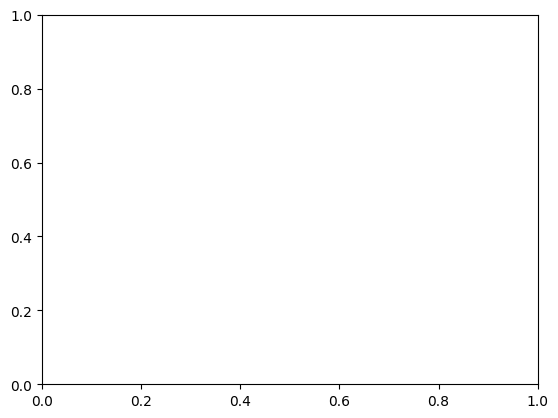

In [ ]:
n = 128

num = 2
x = x_test[num,:,:][None,:,:].cuda()
c = c_test[num,:,:][None,:,:].cuda()
y = y_test[num,:,:][None,:,:].cpu()
c.requires_grad = True
out = model(x,c)
dydc = autograd.grad(out,c,torch.ones_like(out).to(device),retain_graph=True,create_graph=True)[0]
# dydc2 = autograd.grad(dydx,c,torch.ones_like(dydx).to(device),retain_graph=True,create_graph=True)[0]

xl = torch.linspace(0,1,n)

out = out.squeeze()
dydc = dydc.squeeze()
dout = (out[1:] - out[:-1])*(n-1)


plt.figure()
plt.plot(xl.squeeze().cpu().detach().numpy(),out.squeeze().cpu().detach().numpy())
plt.show()
plt.figure()
plt.plot(xl.squeeze().cpu().detach().numpy(),dydc.squeeze().cpu().detach().numpy())
# plt.plot(xl.squeeze().cpu().detach().numpy(),x.squeeze().cpu().detach().numpy())
plt.plot(xl[1:].squeeze().cpu().detach().numpy(),dout.squeeze().cpu().detach().numpy())
# plt.plot(xl.squeeze().cpu().detach().numpy(),dydx2.squeeze().cpu().detach().numpy())
plt.show()